In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

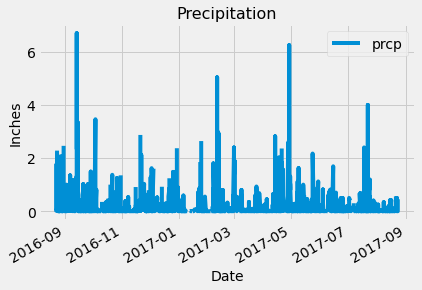

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
sql_statement = """
SELECT date, prcp
FROM measurement
ORDER BY date ASC;
"""

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_date_precep = pd.read_sql(sql_statement, engine)

# Sort the dataframe by date
df_date_precep.sort_values(by="date", inplace=True)
values_int = []
# extract year month and day from the most recent date value
for i in df_date_precep['date'].iloc[-1].split('-'):
    values_int.append(int(i))
yr, month, day = values_int

query_date = dt.date(yr, month, day) - dt.timedelta(days=365)

data = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date).all()
df_12month_precep = pd.DataFrame(data, columns=['date', 'prcp'])
# Use Pandas Plotting with Matplotlib to plot the data
df_12month_precep['date'] = pd.to_datetime(df_12month_precep['date'])
df_12month_precep.plot(x='date', y='prcp')
plt.ylabel('Inches', size=14)
plt.xlabel('Date', size=14)
plt.title('Precipitation', size=16);

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_date_precep.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query((Measurement.station)).group_by(Measurement.station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.sum(Measurement.tobs)/func.count(Measurement.tobs)).\
                where(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

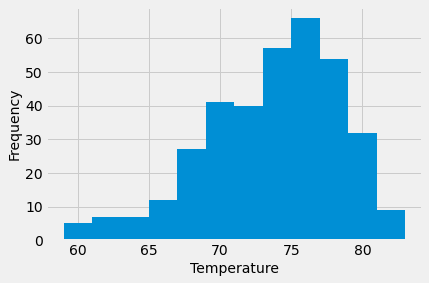

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sql_statement = """
SELECT date, tobs
FROM measurement
WHERE station is "USC00519281";
"""

df_temp = pd.read_sql(sql_statement, engine)

# Sort the dataframe by date
df_temp.sort_values(by="date", ascending=False, inplace=True)

values_int = []
# extract year month and day from the most recent date value
for i in df_temp['date'].iloc[0].split('-'):
    values_int.append(int(i))
yr, month, day = values_int

query_date = dt.date(yr, month, day) - dt.timedelta(days=365)
data = session.query(Measurement.date, Measurement.tobs).\
                where(Measurement.station=='USC00519281').\
                filter(Measurement.date >= query_date).all()
df_12month_temp = pd.DataFrame(data, columns=['date', 'tobs'])
df_12month_temp['tobs'].plot.hist(bins=12)
plt.xlabel('Temperature', size=14)
plt.ylabel('Frequency', size=14);

# Close Session

In [16]:
# Close Session
session.close()